<a href="https://colab.research.google.com/github/moonjune/test-repo/blob/master/kaggle_predictFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
try:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True)
    COLAB = True
    print("Note: using Google CoLab")
    %tensorflow_version 2.x
except:
    print("Note: not using Google CoLab")
    COLAB = False

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
Note: using Google CoLab


In [0]:
import os
os.chdir('/content/drive/My Drive/colab')
!cp kaggle.json /content

In [3]:
os.chdir('/content/')
# kaggle_Predint_Future_Sales
!pip install kaggle

In [4]:
!pip install kaggle --upgrade

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.6)


In [5]:
os.chdir('/content')
!ls -1ha kaggle.json

kaggle.json


In [0]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning 이 일어나지 않도록 
!chmod 600 ~/.kaggle/kaggle.json

In [0]:
import os
if not os.path.exists('/content/predFS/'):
  os.mkdir('/content/predFS/')
os.chdir('/content/predFS/')

In [8]:
!kaggle competitions download -c competitive-data-science-predict-future-sales

  0% 0.00/3.49k [00:00<?, ?B/s]
100% 3.49k/3.49k [00:00<00:00, 3.15MB/s]
  0% 0.00/368k [00:00<?, ?B/s]
100% 368k/368k [00:00<00:00, 51.3MB/s]
  0% 0.00/2.91k [00:00<?, ?B/s]
100% 2.91k/2.91k [00:00<00:00, 3.07MB/s]
  0% 0.00/1.02M [00:00<?, ?B/s]
100% 1.02M/1.02M [00:00<00:00, 69.7MB/s]
  0% 0.00/468k [00:00<?, ?B/s]
100% 468k/468k [00:00<00:00, 146MB/s]
 38% 5.00M/13.3M [00:00<00:00, 52.0MB/s]
100% 13.3M/13.3M [00:00<00:00, 84.9MB/s]


In [9]:
os.chdir('/content/predFS/')
!ls

item_categories.csv  sales_train.csv.zip	shops.csv
items.csv.zip	     sample_submission.csv.zip	test.csv.zip


In [10]:
!kaggle config

usage: kaggle config [-h] {view,set,unset} ...
kaggle config: error: too few arguments


In [0]:
if not os.path.exists('/content/predFS/input'):
  os.mkdir('/content/predFS/input')
!mv item_categories.csv /content/predFS/input
!mv sales_train.csv.zip /content/predFS/input
!mv shops.csv /content/predFS/input
!mv items.csv.zip /content/predFS/input
!mv sample_submission.csv.zip /content/predFS/input
!mv test.csv.zip /content/predFS/input

In [12]:
os.chdir('/content/predFS/input')
!unzip sales_train.csv.zip 
!unzip items.csv.zip
!unzip sample_submission.csv.zip
!unzip test.csv.zip


Archive:  sales_train.csv.zip
  inflating: sales_train.csv         
Archive:  items.csv.zip
  inflating: items.csv               
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   
Archive:  test.csv.zip
  inflating: test.csv                


In [13]:
#https://www.kaggle.com/dlarionov/feature-engineering-xgboost

# feature engineering
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 100)

from itertools import product
from sklearn.preprocessing import LabelEncoder

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from xgboost import XGBRegressor
from xgboost import plot_importance

def plot_features(booster, figsize):    
    fig, ax = plt.subplots(1,1,figsize=figsize)
    return plot_importance(booster=booster, ax=ax)

import time
import sys
import gc
import pickle
sys.version_info

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


sys.version_info(major=3, minor=6, micro=9, releaselevel='final', serial=0)

In [0]:
items = pd.read_csv('../input/items.csv')
shops = pd.read_csv('../input/shops.csv')
cats = pd.read_csv('../input/item_categories.csv')
train = pd.read_csv('../input/sales_train.csv')
# set index to ID to avoid droping it later
test  = pd.read_csv('../input/test.csv').set_index('ID')

**Data Field**

**ID** - an Id that represents a (Shop, Item) tuple within the test set

**shop_id** - unique identifier of a shop

**item_id** - unique identifier of a product

**item_category_id** - unique identifier of item category

**item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure

**item_price** - current price of an item

**date** - date in format dd/mm/yyyy

**date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33

**item_name** - name of item

**shop_name** - name of shop

**item_category_name** - name of item category

In [15]:
train.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


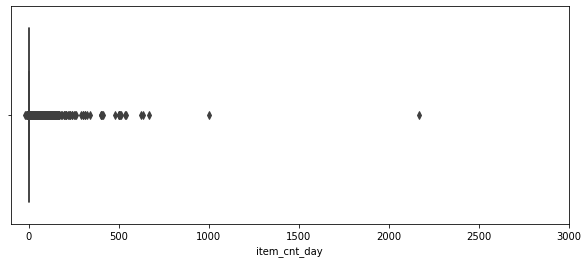

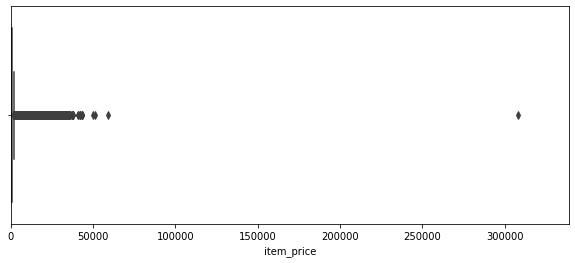

In [16]:
# outlier 찾기
plt.figure(figsize=(10,4)) # 그래프 판 사이즈
plt.xlim(-100, 3000) # x 좌표 설정
sns.boxplot(x=train.item_cnt_day) # 어떤 샵의 어떤 제품의 어떤 날짜 1일 판매량 박스 플롯으로

plt.figure(figsize=(10,4))
plt.xlim(train.item_price.min(), train.item_price.max()*1.1) # x 좌표 설정, 가격 최소값과 최대값을 직접 입력
sns.boxplot(x=train.item_price) # 제품 가격 박스 플롯

In [0]:
#outlier 제거
train = train[train.item_price<100000]  # 가격 100000 미만
train = train[train.item_cnt_day<1001]  # 하루 판매량 1000 이하

In [0]:
# 결측값 채우기
median = train[(train.shop_id==32)&(train.item_id==2973)&(train.date_block_num==4)&(train.item_price>0)].item_price.median()
# 가격 외 위 조건의 항목 중 가격이 음의 값이 존재하며, 이를 같은 조건을 가진 다른 케이스들의 중앙값(median)으로 채움
train.loc[train.item_price<0, 'item_price'] = median 
# loc 다음은 행 값, 열 값을 줄 수 있음. 이 케이스의 경우 가격이 음인 케이스는 하나이므로 행조건에 별다른 조건을 걸지 않음

In [19]:
cats[:20]

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


In [0]:
# 같은 가게를 다르게 입력한 케이스 통합, 단순 데이터 중복이 아닌 내용적 중복을 잡은 것이지만 그냥 스킬적으로만 알자
# Якутск Орджоникидзе, 56
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
# Якутск ТЦ "Центральный"
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
# Жуковский ул. Чкалова 39м²
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [0]:
# 신규 특징(도시명, 서브카테고리 명) 생성
# 작성자는 가게앞 명칭이 도시명으로 되어 있다는 사실에 착안하여 도시명 생성
shops.loc[shops.shop_name == 'Сергиев Посад ТЦ "7Я"', 'shop_name'] = 'СергиевПосад ТЦ "7Я"'
#샵 이름의 도시명 정제
shops['city'] = shops['shop_name'].str.split(' ').map(lambda x: x[0]) 
# shop_name을 ' '으로 스플릿하여 ['도시이름', '샵이름']의 pd.Series가 나오며, map(lambda)의 x는 map앞을 받아 함수처리
shops.loc[shops.city == '!Якутск', 'city'] = 'Якутск'
# 데이터 정제로 보임(특수문자 제거)
shops['city_code'] = LabelEncoder().fit_transform(shops['city'])
# sklearn의 함수로 괄호안 이터레이션에 고유값 별 라벨을 만들어주고 해당 값에 따라 라벨을 붙여줌
shops = shops[['shop_id','city_code']]
# shops 테이블 간소화, 최종적으로 가게 id와 도시이름 code만 남김
# 가게명-도시명 관계 확인 -> 앞부분을 이용한 도시명 추출 -> 도시명 정제 -> 도시명 코드화 -> shop_id, city_code로 정리

# 상위 카테고리(제품 종류)와 하위 카테고리(브랜드? 종류) 구분
cats['split'] = cats['item_category_name'].str.split('-') # -로 연결된 두 개를 분리하여 DF로 남김
cats['type'] = cats['split'].map(lambda x: x[0].strip()) # 제품 유형을 type으로 
cats['type_code'] = LabelEncoder().fit_transform(cats['type']) # 제품 유형 라벨 붙이기
# if subtype is nan then type
cats['subtype'] = cats['split'].map(lambda x: x[1].strip() if len(x) > 1 else x[0].strip())  # 브랜드가 없으면 유형으로
cats['subtype_code'] = LabelEncoder().fit_transform(cats['subtype'])# 라벨링
cats = cats[['item_category_id','type_code', 'subtype_code']] # id와 코드들로만 테이블 정리

items.drop(['item_name'], axis=1, inplace=True) # 아이템 id와 카테고리 id만 남김

In [22]:
#월별 판매량으로 정리
len(list(set(test.item_id) - set(test.item_id).intersection(set(train.item_id)))), len(list(set(test.item_id))), len(test)
#test 셋에만 존재하는 아이템 종류 수, 테스트에 있는 아이템 종류 총 수, 테스트 총 케이스 수

(363, 5100, 214200)

In [23]:
ts = time.time() # 셀 시작 시간
matrix = [] 
cols = ['date_block_num','shop_id','item_id']
for i in range(34): #훈련 세트의 날짜 블록이 34개
    sales = train[train.date_block_num==i] # 날짜 블록별로 DF 생성
    matrix.append(np.array(list(product([i], sales.shop_id.unique(), sales.item_id.unique())), dtype='int16'))
      # len(i)와 sales.shop_id.unique(), sales.item_id.unique()의 카테시안 곱이 이뤄지며,
      # (1 * len(sales.shop_id.unique()), len(sales.item_id.unique()),3)의 리스트 생성 후 리스트에 더해진다.
matrix = pd.DataFrame(np.vstack(matrix), columns=cols) 
# vstack은 가장 작은 리스트 단위를 쌓아주는 것으로 리스트 내 원소 숫자는 같지만 리스트들의 숫자가 케이스별로 다를 경우
# vstack류를 사용하여 정렬시킬 수 있을 것
matrix['date_block_num'] = matrix['date_block_num'].astype(np.int8) # 정수 타입 변환
matrix['shop_id'] = matrix['shop_id'].astype(np.int8) # 정수 타입 변환
matrix['item_id'] = matrix['item_id'].astype(np.int16)  # 정수 타입 변환 
matrix.sort_values(cols,inplace=True) 
time.time() - ts

12.674329042434692

In [0]:
train['revenue'] = train['item_price'] *  train['item_cnt_day']

In [25]:
ts = time.time()
group = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day': ['sum']})
# 월 블록 - 샵 id - 아이템 id로 테이블을 만들고 하루 판매량의 합을 값으로 설정
group.columns = ['item_cnt_month'] # 값 열을 월별 판매량으로 명명(date_block은 월 단위 순서임)
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=cols, how='left') # 모든 케이스가 월단위 판매량을 가지게 함
matrix['item_cnt_month'] = (matrix['item_cnt_month']
                                .fillna(0) 
                                .clip(0,20) # NB clip target here # 최대-최소 바운더리
                                .astype(np.float16))
time.time() - ts

6.18713116645813

In [0]:
sample_test = pd.read_csv("sample_submission.csv")

In [27]:
du = 20
sample_test[du*10:(du+1)*10]

,ID,item_cnt_month
200,200,0.5
201,201,0.5
202,202,0.5
203,203,0.5
204,204,0.5
205,205,0.5
206,206,0.5
207,207,0.5
208,208,0.5
209,209,0.5


In [28]:
""" 이상에서 트레이닝 셋에서 처리된 것을 정리하면, 
1. outlier 제외 - 시각적 도구 활용 판단 - 가격 100000 이상 or 판매량 1000개 이상 케이스 제거
2. 결측치 대체 - 중앙값 - 가격이 (-)인 케이스 대체
3. 코드 오류 수정 - 중복 데이터 - 중복 데이터 코드 통합
4. 신규 특성 생성1 - 텍스트 마이닝(직접 읽어서?) - 가게 정보에서 지역정보 추출
5. 신규 특성 생성2 - 텍스트 마이닝(기계적 규칙 존재) - 유형 정보에서 대분류와 브랜드(?) 카테고리 추출
6. 타겟값 변형 - 그룹핑 및 총합 - 목적 
  6.1 test의 고유 유형 사례 확인
  6.2 train 데이터를 (시간, 가게, 아이템) 카테시안 곱으로 발생 가능한 모든 사례 DF 생성
  6.3 train 데이터의 (시점, 가게, 아이템)별 월 매출 값을 구한 뒤 6.2 DF에 left 조인
  6.4 월 매출을 0~20 사이의 값으로 범주화(왜일까;;?)"""

' 이상에서 트레이닝 셋에서 처리된 것을 정리하면, \n1. outlier 제외 - 시각적 도구 활용 판단 - 가격 100000 이상 or 판매량 1000개 이상 케이스 제거\n2. 결측치 대체 - 중앙값 - 가격이 (-)인 케이스 대체\n3. 코드 오류 수정 - 중복 데이터 - 중복 데이터 코드 통합\n4. 신규 특성 생성1 - 텍스트 마이닝(직접 읽어서?) - 가게 정보에서 지역정보 추출\n5. 신규 특성 생성2 - 텍스트 마이닝(기계적 규칙 존재) - 유형 정보에서 대분류와 브랜드(?) 카테고리 추출\n6. 타겟값 변형 - 그룹핑 및 총합 - 목적 \n  6.1 test의 고유 유형 사례 확인\n  6.2 train 데이터를 (시간, 가게, 아이템) 카테시안 곱으로 발생 가능한 모든 사례 DF 생성\n  6.3 train 데이터의 (시점, 가게, 아이템)별 월 매출 값을 구한 뒤 6.2 DF에 left 조인\n  6.4 월 매출을 0~20 사이의 값으로 범주화(왜일까;;?)'

In [0]:
# Test set 처리
test['date_block_num'] = 34 # testset 은 34(train set 의 다음 한달)로 처리
test['date_block_num'] = test['date_block_num'].astype(np.int8)
test['shop_id'] = test['shop_id'].astype(np.int8)
test['item_id'] = test['item_id'].astype(np.int16)

In [30]:
ts = time.time()
matrix = pd.concat([matrix, test], ignore_index=True, sort=False, keys=cols) # train, test 데이터 통합
matrix.fillna(0, inplace=True) # 34 month
time.time() - ts

0.08236336708068848

In [31]:
# 넣을 데이터의 결합
ts = time.time()
matrix = pd.merge(matrix, shops, on=['shop_id'], how='left') # shop 정보 붙임
matrix = pd.merge(matrix, items, on=['item_id'], how='left') # 아이템 정보 붙임
matrix = pd.merge(matrix, cats, on=['item_category_id'], how='left') # 카테고리 정보 붙임
matrix['city_code'] = matrix['city_code'].astype(np.int8) # NaN 시 형식 바뀌는 걸 방지하고 회귀 가능하게
matrix['item_category_id'] = matrix['item_category_id'].astype(np.int8)
matrix['type_code'] = matrix['type_code'].astype(np.int8)
matrix['subtype_code'] = matrix['subtype_code'].astype(np.int8)
time.time() - ts

4.62277889251709

In [0]:
def lag_feature(df, lags, col):
    tmp = df[['date_block_num','shop_id','item_id',col]] 
    for i in lags:
        shifted = tmp.copy()
        shifted.columns = ['date_block_num','shop_id','item_id', col+'_lag_'+str(i)]
        shifted['date_block_num'] += i
        df = pd.merge(df, shifted, on=['date_block_num','shop_id','item_id'], how='left')
    return df
# (shop, item)의 n달 전 케이스를 붙이는 중, 최대 4개

In [33]:
ts = time.time()
matrix = lag_feature(matrix, [1,2,3,6,12], 'item_cnt_month')
time.time() - ts

40.65371894836426

In [34]:
# 평균 인코딩 특성?
group = matrix.groupby(['date_block_num']).agg({'item_cnt_month': ['mean']}) #월별 평균 총 판매량
group.columns = [ 'date_avg_item_cnt' ] # 
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num'], how='left') # 평균 추가
matrix['date_avg_item_cnt'] = matrix['date_avg_item_cnt'].astype(np.float16) # 
matrix = lag_feature(matrix, [1], 'date_avg_item_cnt') # 평균로 랙 추가
matrix.drop(['date_avg_item_cnt'], axis=1, inplace=True) # 해당기간 평균 데이터 삭제
time.time() - ts

52.31403183937073

In [35]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id']).agg({'item_cnt_month': ['mean']}) # (기간, 아이템) 월 평균
group.columns = [ 'date_item_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left') #위랑 동일
matrix['date_item_avg_item_cnt'] = matrix['date_item_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_item_avg_item_cnt')
matrix.drop(['date_item_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

47.84742307662964

In [36]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id']).agg({'item_cnt_month': ['mean']}) # (기간,샵)별 월 판매량 평균
group.columns = [ 'date_shop_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left') # 위랑 동일
matrix['date_shop_avg_item_cnt'] = matrix['date_shop_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1,2,3,6,12], 'date_shop_avg_item_cnt')
matrix.drop(['date_shop_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

47.88270139694214

In [37]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_category_id']).agg({'item_cnt_month': ['mean']}) #(기간, 제품 카테고리)
group.columns = [ 'date_cat_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_category_id'], how='left') # 위랑 동일..
matrix['date_cat_avg_item_cnt'] = matrix['date_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_cat_avg_item_cnt') # 1달전 판매량만 가져 옴
matrix.drop(['date_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.022008895874023

In [38]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'item_category_id']).agg({'item_cnt_month': ['mean']})
# (기간, 샵, 제품 카테고리) 월 평균 판매량
group.columns = ['date_shop_cat_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'item_category_id'], how='left')
matrix['date_shop_cat_avg_item_cnt'] = matrix['date_shop_cat_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_cat_avg_item_cnt') # 역시 한달만
matrix.drop(['date_shop_cat_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.876180171966553

In [39]:
group[:10]

,date_block_num,shop_id,item_category_id,date_shop_cat_avg_item_cnt
0,0,2,0,0.000000
1,0,2,1,0.000000
2,0,2,2,0.675781
3,0,2,3,4.500000
4,0,2,4,0.909180
5,0,2,5,0.370361
6,0,2,6,0.631348
7,0,2,9,0.000000
8,0,2,11,0.588379
9,0,2,13,0.600098


In [40]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'type_code']).agg({'item_cnt_month': ['mean']}) 
# (기간, 샵, 대유형) 월 평균 판매량
group.columns = ['date_shop_type_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'type_code'], how='left')
matrix['date_shop_type_avg_item_cnt'] = matrix['date_shop_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_type_avg_item_cnt')
matrix.drop(['date_shop_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

14.907904148101807

In [41]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'shop_id', 'subtype_code']).agg({'item_cnt_month': ['mean']})
# (기간, 샵, 브랜드 유형) 월 평균 판매량
group.columns = ['date_shop_subtype_avg_item_cnt']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'shop_id', 'subtype_code'], how='left')
matrix['date_shop_subtype_avg_item_cnt'] = matrix['date_shop_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_shop_subtype_avg_item_cnt')
matrix.drop(['date_shop_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.083939552307129

In [42]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'city_code']).agg({'item_cnt_month': ['mean']})
# (기간, 도시) 월 평균 판매량
group.columns = [ 'date_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'city_code'], how='left')
matrix['date_city_avg_item_cnt'] = matrix['date_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_city_avg_item_cnt')
matrix.drop(['date_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.032070398330688

In [43]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'item_id', 'city_code']).agg({'item_cnt_month': ['mean']})
# (기간, 상품, 도시) 월 평균 판매량
group.columns = [ 'date_item_city_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'item_id', 'city_code'], how='left')
matrix['date_item_city_avg_item_cnt'] = matrix['date_item_city_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_item_city_avg_item_cnt')
matrix.drop(['date_item_city_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

23.949413061141968

In [44]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'type_code']).agg({'item_cnt_month': ['mean']})
# (기간, 제품 유형 코드) 월 평균 판매량
group.columns = [ 'date_type_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'type_code'], how='left')
matrix['date_type_avg_item_cnt'] = matrix['date_type_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_type_avg_item_cnt')
matrix.drop(['date_type_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.579660892486572

In [45]:
ts = time.time()
group = matrix.groupby(['date_block_num', 'subtype_code']).agg({'item_cnt_month': ['mean']})
# (기간, 브랜드 유형 코드) 월 평균 판매량
group.columns = [ 'date_subtype_avg_item_cnt' ]
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num', 'subtype_code'], how='left')
matrix['date_subtype_avg_item_cnt'] = matrix['date_subtype_avg_item_cnt'].astype(np.float16)
matrix = lag_feature(matrix, [1], 'date_subtype_avg_item_cnt')
matrix.drop(['date_subtype_avg_item_cnt'], axis=1, inplace=True)
time.time() - ts

15.100733518600464

In [46]:
# 추세 특성 - 6개월 트렌드
ts = time.time()
group = train.groupby(['item_id']).agg({'item_price': ['mean']}) # 제품 가격 평균 데이터(샵, 시간 무시)
group.columns = ['item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['item_id'], how='left') # 평균가격 추가
matrix['item_avg_item_price'] = matrix['item_avg_item_price'].astype(np.float16)

group = train.groupby(['date_block_num','item_id']).agg({'item_price': ['mean']}) # 제품별 시간별 평균
group.columns = ['date_item_avg_item_price']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','item_id'], how='left') #  제품,시간 평균 추가
matrix['date_item_avg_item_price'] = matrix['date_item_avg_item_price'].astype(np.float16)

lags = [1,2,3,4,5,6]
matrix = lag_feature(matrix, lags, 'date_item_avg_item_price') # 제품 시간 평균의 6개월간 시간 항목 추가

for i in lags:
    matrix['delta_price_lag_'+str(i)] = \
        (matrix['date_item_avg_item_price_lag_'+str(i)] - matrix['item_avg_item_price']) / matrix['item_avg_item_price']

# (시간별 아이템 가격 평균 - 전체기간 아이템 가격 평균) / 전체기간 아이템 가격 평균 컬럼 추가

def select_trend(row):
    for i in lags:
        if row['delta_price_lag_'+str(i)]:
            return row['delta_price_lag_'+str(i)]
    return 0

# apply 함수로 활용될 함수, 변화량이 있으면 변화량, 없으면 0 출력
    
matrix['delta_price_lag'] = matrix.apply(select_trend, axis=1)
matrix['delta_price_lag'] = matrix['delta_price_lag'].astype(np.float16)
matrix['delta_price_lag'].fillna(0, inplace=True)

# https://stackoverflow.com/questions/31828240/first-non-null-value-per-row-from-a-list-of-pandas-columns/31828559
# matrix['price_trend'] = matrix[['delta_price_lag_1','delta_price_lag_2','delta_price_lag_3']].bfill(axis=1).iloc[:, 0]
# Invalid dtype for backfill_2d [float16]

fetures_to_drop = ['item_avg_item_price', 'date_item_avg_item_price'] 
for i in lags:
    fetures_to_drop += ['date_item_avg_item_price_lag_'+str(i)]
    fetures_to_drop += ['delta_price_lag_'+str(i)]
  
matrix.drop(fetures_to_drop, axis=1, inplace=True)

# 시간별 - 전체평균 계산이 끝난 뒤 재료 열 모두 소거

time.time() - ts

404.6605951786041

In [47]:
# 샵 수익 추이
ts = time.time()
group = train.groupby(['date_block_num','shop_id']).agg({'revenue': ['sum']}) # 월별 샵별 수익 총합
group.columns = ['date_shop_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['date_block_num','shop_id'], how='left')
matrix['date_shop_revenue'] = matrix['date_shop_revenue'].astype(np.float32)

group = group.groupby(['shop_id']).agg({'date_shop_revenue': ['mean']}) # 전체 샵별 수익 평균
group.columns = ['shop_avg_revenue']
group.reset_index(inplace=True)

matrix = pd.merge(matrix, group, on=['shop_id'], how='left')
matrix['shop_avg_revenue'] = matrix['shop_avg_revenue'].astype(np.float32)

matrix['delta_revenue'] = (matrix['date_shop_revenue'] - matrix['shop_avg_revenue']) / matrix['shop_avg_revenue']
# (월별 샵 수익 - 샵 평균 수익)/샵 평균 수익 항목 생성
matrix['delta_revenue'] = matrix['delta_revenue'].astype(np.float16)

matrix = lag_feature(matrix, [1], 'delta_revenue')
# 전월 (월별 샵 수익 - 샵 평균 수익)/샵 평균 수익 추가
matrix.drop(['date_shop_revenue','shop_avg_revenue','delta_revenue'], axis=1, inplace=True)
# 평균들과 당월 트렌드는 삭제(전월 트렌드만 남김)
time.time() - ts

18.828193187713623

In [0]:
matrix['month'] = matrix['date_block_num'] % 12 # 월로 표시되도록 나눔

In [0]:
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31]) # 윤년이 없다는 가정하에 12월의 숫자
matrix['days'] = matrix['month'].map(days).astype(np.int8) # 일 데이터 매칭

In [50]:
ts = time.time() 
cache = {}
matrix['item_shop_last_sale'] = -1 # -1 넣는 이유는 type 원활히 하기 위함
matrix['item_shop_last_sale'] = matrix['item_shop_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows(): # iterrows는 idx와 한 행의 전 열 데이터가 나온다, idx는 하나의 숫자, row는 pd.series
    key = str(row.item_id)+' '+str(row.shop_id) #key란 한 열의 item_id shop_id가 합해진 str이 된다.
    if key not in cache: # cache 안에 key라는 key가 없으면서
        if row.item_cnt_month!=0: # 그 행의 item_cnt_month가 0이 아니면
            cache[key] = row.date_block_num # 위의 key를 key로 하는 cache에 date_block_num[그 달 넘버]을 넣음 
    else: # cache 안에 key라는 key가 존재하면(item_id, shop_id의 달이 입력된 케이스라면)
        last_date_block_num = cache[key] # 행의 last_date_block_num에 cache[key]의 값(직전 달)을 넣음 
        matrix.at[idx, 'item_shop_last_sale'] = row.date_block_num - last_date_block_num
        # DF의 idx 행이며, 새로 생긴 행인 'item_shop_last_sale' 컬럼에 (데이터 월과 직전 월 개월 차이)입력
        cache[key] = row.date_block_num # 위 연산이 종료 된 후 cache[key]의 월은 마지막으로 처리한 데이터의 달을 입력

# 이 작업이 종료되면 matrix는 'item_shop_last_sale' 컬럼을 가지게 되며,
# 얘는 아이템_샵 기준 판매량의 현재 달 기록 과 과거달 기록 간 차이기간 데이터를 생성
time.time() - ts

2026.6691627502441

In [51]:
ts = time.time()
cache = {}
matrix['item_last_sale'] = -1
matrix['item_last_sale'] = matrix['item_last_sale'].astype(np.int8)
for idx, row in matrix.iterrows():    
    key = row.item_id # 이번에 key는 item_id
    if key not in cache: # cache에 key가 없고
        if row.item_cnt_month!=0: # 아이템 판매량이 0이 아니면
            cache[key] = row.date_block_num # 그걸 넣음
    else:
        last_date_block_num = cache[key] # 전달 데이터 넣고
        if row.date_block_num>last_date_block_num: # 현재 달이 전달 데이터(위에서 만들어졌나?)가 크면
            matrix.at[idx, 'item_last_sale'] = row.date_block_num - last_date_block_num 
            # item_last_sale은 현재 달과 지난 달의 차이로 입력
            cache[key] = row.date_block_num         

# 이 작업이 마치면 matrix는 아이템 판매데이터의 현재 달과 직전 달의 차이 기간를 알 수 있음
time.time() - ts

1338.3456447124481

In [52]:
ts = time.time()
matrix['item_shop_first_sale'] = matrix['date_block_num'] - matrix.groupby(['item_id','shop_id'])['date_block_num'].transform('min')
# 매트릭스 DF는 item_id, shop_id, data_block_num으로 구성되어 있기 때문에 위의 그루핑이 매트릭스 수를 변경시키진 않을 것
# 현 판매 월과 item과 shop 기준 첫번째 판매월의 차이를 구하고 있음. 해당 계산에서 도출 되는 것은 그 컬럼의 판매기간임
matrix['item_first_sale'] = matrix['date_block_num'] - matrix.groupby('item_id')['date_block_num'].transform('min')
# 위와 마찬가지

# 이 셀의 계산으로 도출되는 것은 item_shop 기준, item 기준 첫 월부터 데이터의 월까지 기간을 구해줌
time.time() - ts

2.7676823139190674

Final preparation

In [53]:
ts = time.time()
matrix = matrix[matrix.date_block_num > 11]
# 11개월차 이상의 데이터만 남김
time.time() - ts

2.6678719520568848

In [54]:
ts = time.time()
def fill_na(df): # fill_na는 DF를 인자로 넣음
    for col in df.columns: # 컬럼명을 str로 돌리는데
        if ('_lag_' in col) & (df[col].isnull().any()): # 컬럼명에 '_lag_'이 있고, DF의 그 컬럼에 isnull이 True인 데이터가 하나라도 있고,
            if ('item_cnt' in col): # 컬럼명에 item_cnt가 있다면(거기가 판매량 데이터, 직전이든 어디든)
                df[col].fillna(0, inplace=True) # 그 컬럼의 na데이터엔 0을 대체해라
    return df # 그리고 df 출력

matrix = fill_na(matrix)
time.time() - ts

1.9914360046386719

In [55]:
matrix.columns

Index(['date_block_num', 'shop_id', 'item_id', 'item_cnt_month', 'city_code',
       'item_category_id', 'type_code', 'subtype_code', 'item_cnt_month_lag_1',
       'item_cnt_month_lag_2', 'item_cnt_month_lag_3', 'item_cnt_month_lag_6',
       'item_cnt_month_lag_12', 'date_avg_item_cnt_lag_1',
       'date_item_avg_item_cnt_lag_1', 'date_item_avg_item_cnt_lag_2',
       'date_item_avg_item_cnt_lag_3', 'date_item_avg_item_cnt_lag_6',
       'date_item_avg_item_cnt_lag_12', 'date_shop_avg_item_cnt_lag_1',
       'date_shop_avg_item_cnt_lag_2', 'date_shop_avg_item_cnt_lag_3',
       'date_shop_avg_item_cnt_lag_6', 'date_shop_avg_item_cnt_lag_12',
       'date_cat_avg_item_cnt_lag_1', 'date_shop_cat_avg_item_cnt_lag_1',
       'date_shop_type_avg_item_cnt_lag_1',
       'date_shop_subtype_avg_item_cnt_lag_1', 'date_city_avg_item_cnt_lag_1',
       'date_item_city_avg_item_cnt_lag_1', 'date_type_avg_item_cnt_lag_1',
       'date_subtype_avg_item_cnt_lag_1', 'delta_price_lag',
       'delta

In [56]:
matrix.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6639294 entries, 4488710 to 11128003
Data columns (total 40 columns):
 #   Column                                Dtype  
---  ------                                -----  
 0   date_block_num                        int8   
 1   shop_id                               int8   
 2   item_id                               int16  
 3   item_cnt_month                        float16
 4   city_code                             int8   
 5   item_category_id                      int8   
 6   type_code                             int8   
 7   subtype_code                          int8   
 8   item_cnt_month_lag_1                  float16
 9   item_cnt_month_lag_2                  float16
 10  item_cnt_month_lag_3                  float16
 11  item_cnt_month_lag_6                  float16
 12  item_cnt_month_lag_12                 float16
 13  date_avg_item_cnt_lag_1               float16
 14  date_item_avg_item_cnt_lag_1          float16
 15  date_ite

In [0]:
matrix.to_pickle('data.pkl') # DF를 피클로 저장
# 메모리를 차지하는 데이터들 삭제
del matrix
del cache
del group
del items
del shops
del cats
del train
# leave test for submission 
gc.collect();

Xgboost

In [0]:
data = pd.read_pickle('data.pkl')

In [0]:
data = data[[
    'date_block_num',
    'shop_id',
    'item_id',
    'item_cnt_month',
    'city_code',
    'item_category_id',
    'type_code',
    'subtype_code',
    'item_cnt_month_lag_1',
    'item_cnt_month_lag_2',
    'item_cnt_month_lag_3',
    'item_cnt_month_lag_6',
    'item_cnt_month_lag_12',
    'date_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_1',
    'date_item_avg_item_cnt_lag_2',
    'date_item_avg_item_cnt_lag_3',
    'date_item_avg_item_cnt_lag_6',
    'date_item_avg_item_cnt_lag_12',
    'date_shop_avg_item_cnt_lag_1',
    'date_shop_avg_item_cnt_lag_2',
    'date_shop_avg_item_cnt_lag_3',
    'date_shop_avg_item_cnt_lag_6',
    'date_shop_avg_item_cnt_lag_12',
    'date_cat_avg_item_cnt_lag_1',
    'date_shop_cat_avg_item_cnt_lag_1',
    #'date_shop_type_avg_item_cnt_lag_1',
    #'date_shop_subtype_avg_item_cnt_lag_1',
    'date_city_avg_item_cnt_lag_1',
    'date_item_city_avg_item_cnt_lag_1',
    #'date_type_avg_item_cnt_lag_1',
    #'date_subtype_avg_item_cnt_lag_1',
    'delta_price_lag',
    'month',
    'days',
    'item_shop_last_sale',
    'item_last_sale',
    'item_shop_first_sale',
    'item_first_sale',
]] # [리스트 안의 데이터들로 지정]

In [0]:
X_train = data[data.date_block_num < 33].drop(['item_cnt_month'], axis=1) # 33기 이전의 데이터들(11~33)
Y_train = data[data.date_block_num < 33]['item_cnt_month'] # 33기 이전의 데이터들
X_valid = data[data.date_block_num == 33].drop(['item_cnt_month'], axis=1) # 33기인 데이터들
Y_valid = data[data.date_block_num == 33]['item_cnt_month'] # 33기인 데이터들
X_test = data[data.date_block_num == 34].drop(['item_cnt_month'], axis=1) # 34기의 데이터들

In [0]:
del data # 데이터 삭제
gc.collect(); # 메모리 삭제?

In [62]:
ts = time.time()

model = XGBRegressor(
    max_depth=8, # 각 트리의 최대 깊이
    n_estimators=1000, # 결정 트리의 개수
    min_child_weight=300, 
    # 트리 분기 기준값으로 끝자락 인스턴스 가중치 합이 얘보다 작으면 더이상 분기하지 않음(이 수가 클수록 분기를 안해서 보수적이됨)
    colsample_bytree=0.8, 
    subsample=0.8, 
    eta=0.3,    
    seed=42)

model.fit(
    X_train, 
    Y_train, 
    eval_metric="rmse", 
    eval_set=[(X_train, Y_train), (X_valid, Y_valid)], 
    verbose=True, 
    early_stopping_rounds = 100)

time.time() - ts

[08:27:08] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[08:27:09] WARNING: /workspace/src/learner.cc:686: Tree method is automatically selected to be 'approx' for faster speed. To use old behavior (exact greedy algorithm on single machine), set tree_method to 'exact'.
[0]	validation_0-rmse:1.12413	validation_1-rmse:1.11704
Multiple eval metrics have been passed: 'validation_1-rmse' will be used for early stopping.

Will train until validation_1-rmse hasn't improved in 100 rounds.
[1]	validation_0-rmse:1.08616	validation_1-rmse:1.08412
[2]	validation_0-rmse:1.05295	validation_1-rmse:1.05309
[3]	validation_0-rmse:1.01018	validation_1-rmse:1.02723
[4]	validation_0-rmse:0.984142	validation_1-rmse:1.00866
[5]	validation_0-rmse:0.962195	validation_1-rmse:0.990075
[6]	validation_0-rmse:0.944697	validation_1-rmse:0.975021
[7]	validation_0-rmse:0.922515	validation_1-rmse:0.96105
[8]	validation_0-rmse:0.90889	validation_1-rm

KeyboardInterrupt: ignored

In [0]:
Y_pred = model.predict(X_valid).clip(0, 20)
Y_test = model.predict(X_test).clip(0, 20)

submission = pd.DataFrame({
    "ID": test.index, 
    "item_cnt_month": Y_test
})
submission.to_csv('xgb_submission.csv', index=False)

# save predictions for an ensemble
pickle.dump(Y_pred, open('xgb_train.pickle', 'wb'))
pickle.dump(Y_test, open('xgb_test.pickle', 'wb'))

In [0]:
plot_features(model, (10,14))